# let's make an app that uses a model!
- step 1: figure out what data you want to use
- step 2: data cleaning
 

In [20]:
import fastbook
import fastai.vision.widgets as widgets
from fastdownload import download_url
from pathlib import Path

In [21]:
fastbook.doc(fastbook.search_images_ddg)

search_images_ddg(term, max_images=200)
Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [ ]:
urls_grizzly_bears = fastbook.search_images_ddg("grizzly bear")
print(f'{len(urls_grizzly_bears)=}')

dest_grizzly_bears = 'images/grizzly.jpg'
download_url(urls_grizzly_bears[0], dest_grizzly_bears, show_progress=True)
im_grizzly_bear = fastbook.Image.open(dest_grizzly_bears)
im_grizzly_bear.to_thumb(128, 128)

In [23]:
bear_types = 'grizzly', 'black', 'teddy'
path_bears = Path('bears')

if not path_bears.exists():
    print("downloading images...")
    path_bears.mkdir()
    for bear_type in bear_types:
        dest = (path_bears/bear_type)
        dest.mkdir(exist_ok=True)
        urls = fastbook.search_images_ddg(f'{bear_type} bear')
        fastbook.download_images(dest, urls=urls)
else:
    print("images downnloaded already")

fns = fastbook.get_image_files(path_bears)
print(f'{len(fns)=}')

failed = fastbook.verify_images(fns)
print(f'{len(failed)=}')
failed.map(Path.unlink)

images downnloaded already
len(fns)=529
len(failed)=0


(#0) []

In [24]:
?fastbook.get_image_files

Signature: fastbook.get_image_files(path, recurse=True, folders=None)
Docstring: Get image files in `path` recursively, only in `folders`, if specified.
File:      ~/Documents/interview_prep_2025/practical_deep_learning/.venv/lib/python3.12/site-packages/fastai/data/transforms.py
Type:      function

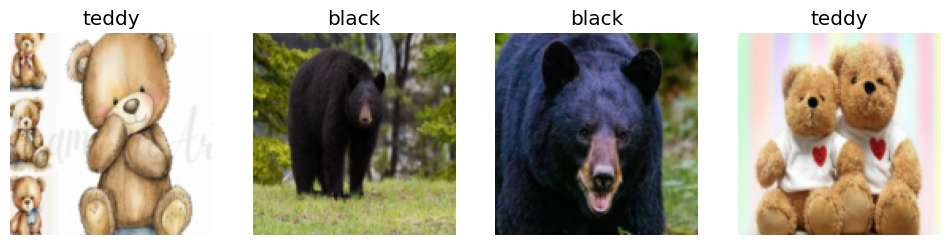

In [25]:
# TRAIN MODEL and USE IT TO CLEAN UP THE DATA
# howard's suggestion that sounds backwwards: before you clean the data, train the model

# create DataBlock
bears = fastbook.DataBlock(  # produces template for creating a DataLoaders
    blocks = (fastbook.ImageBlock, fastbook.CategoryBlock),
    get_items = fastbook.get_image_files,  # The get_image_files function takes a path, and returns a list of all of the images in that path (recursively, by default)
    splitter = fastbook.RandomSplitter(valid_pct=0.2, seed=42),
    get_y = fastbook.parent_label,  # parent_label is a function provided by fastai that simply gets the name of the folder a file is in.
    item_tfms = fastbook.RandomResizedCrop(128, min_scale=0.5),  # tem transforms are pieces of code that run on each individual item
    batch_tfms = fastbook.aug_transforms,
    # itmes_tfms = fastbook.Resize(128),  # Resize crops the images to fit in a swuare shape of the requested size
    # alternatively, you can do item_tfms = fastbook.Resize(128, fastbook.ResizeMethod.Squish)
    # alternatively, you can do item_tfms = fastbook.Resize(128, fastbook.ResizeMethod.Pad, pad_mode='zeros') gets whole image and correctly aspect ratio
    # alternatively, you can do item_tfms = fastbook.RandomResizedCrop(128, min_scale=0.3)  gets different bit of image everytime
    # alternatively, you can do item_tfms = fastbook.Resize(128), batch_tfms=fastbook.aug_transforms()
)
# use DataBlock to create dataloaders
# DataLoaders is a thin class that just stores whatever DataLoader objects you pass to it, and makes them available as train and valid.
# i.e. provides the data for your model
dls_bears = bears.dataloaders(path_bears)
dls_bears.valid.show_batch(max_n=4, nrows=1)


In [26]:
learn_bears = fastbook.vision_learner(dls_bears, fastbook.resnet18, metrics=fastbook.error_rate)
learn_bears.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.249660,0.300114,0.057143,00:11


/Users/denisesalazar/Documents/interview_prep_2025/practical_deep_learning/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.263252,0.299854,0.057143,00:12
1,0.216016,0.305550,0.047619,00:12
2,0.173249,0.314389,0.047619,00:12
3,0.131100,0.307462,0.047619,00:12


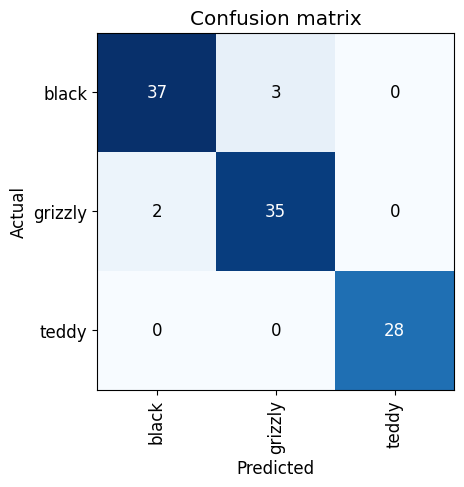

In [27]:
# CONFUSION MATRIX 
# - confusion matrix calculated using the validation set
# - only meaningful when labels are categories
# - 4 times when photo was a black bear, and a grizzly was predicted, etc.
# - 0 times did the model predict teddy bear incorrectly
interp = fastbook.ClassificationInterpretation.from_learner(learn_bears)
interp.plot_confusion_matrix()

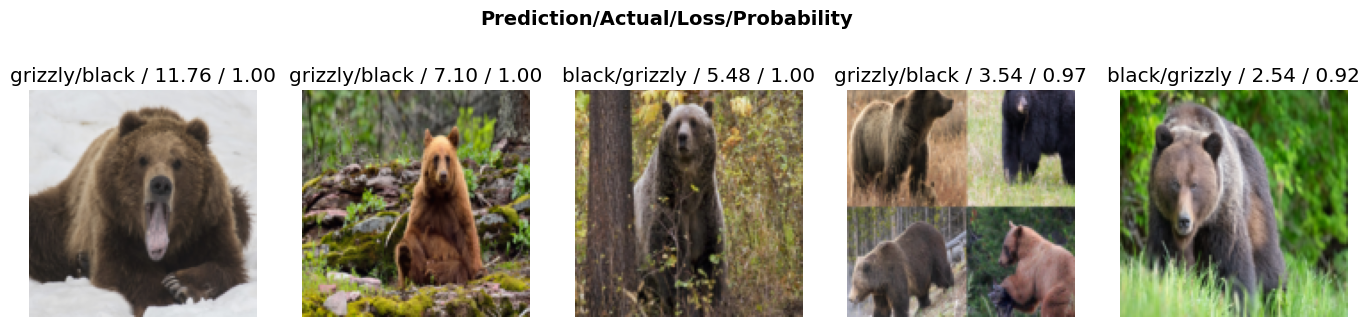

In [28]:
# it's helpful to see where errors are occuring
# we can sort images by loss
# and get images with the highest loss in the dataset
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

In [29]:
# ImageClassifierCleaner - handy fasti GUI for that allows you to choose the category, training vs val set,  view the highest loss images (images)
# along with menus in order to remove or relabel images
cleaner = widgets.ImageClassifierCleaner(learn_bears)
cleaner

/Users/denisesalazar/Documents/interview_prep_2025/practical_deep_learning/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [30]:
import shutil
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path_bears/cat)

# Steps to deploy app
- create model and train on kaggle (free GPU use) and export model pickle file
- on your own computer, setup learner with that model pkl file; you can predict, launch app via gradio 
- to share model, push git repo with model pickle to HuggingFace Space
- try model on Space

# Space/Gradio
- gradio is a way to demo your ML model with a friendly web interface; see gradio docs for different widgets; great for prototypes
- HuggingFace Spaces is a free-to-use platform for hosting machine learning demos and apps. The Spaces environment provided is a CPU environment with 16 GB RAM and 8 cores.
- space app comes with API as well, run on HF space link, so you can create your own app that calls this API
- gradio/hugging space tutorial: https://www.tanishq.ai/blog/posts/2021-11-16-gradio-huggingface.html

# Use model for inference
- export() method saves both architecture and parameters to 'export.pkl'. You'll need this file wherever you deploy your app to.
- To create our inference learner from the exported file, we use load_learner
- pass a filename to the inference learner to make a prediction for that one image

# Use model in an app
- To use our model in an application, we can simply treat the predict method as a regular function.
- You almost certainly do not need a GPU to serve your model in production. 

In [31]:
learn_bears.export('bears.pkl')
path_bears_pkl = Path()
path_bears_pkl.ls(file_exts='.pkl')

(#1) [Path('bears.pkl')]

In [ ]:
# At inference time, you can access the DataLoaders as an attribute of the Learner
learn_inf = fastbook.load_learner(path_bears_pkl/'bears.pkl')
print(f'{learn_inf.dls.vocab=}')

In [33]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([6.3392e-05, 9.9933e-01, 6.0528e-04]))

# How to Avoid Disaster
- recommended: https://www.oreilly.com/library/view/building-machine-learning/9781492045106/
- risks - you can never fully understand the entire behaviour of your neural network
    - out-of-domain data - there may be data that our model sees in production which is very different to what it saw during training
    - domain shift - the type of data that our model sees changes over time
- how to mitigate risks
    1. manual process - run model in parallel, humans check predictions
    2. limit scope deployment - time or geography limited with human supervision
    3. gradual expansion of scope - have a good reporting system and consider all the ways the system can go wrong
- your model may change the behaviour of the system it is a part of. If there is bias, feedback loops can make it worse.
- you need ongoing monitoring systems and human oversight
